In [48]:
LABEL_MIN_COUNT = 50

In [1]:
%load_ext lab_black

In [93]:
import itertools

import pandas as pd

import spacy
from spacy import displacy

import gensim
import fasttext
import umap
import altair as alt

from tqdm.notebook import tqdm

## Load Data and NLP Model

In [10]:
df_recipes = pd.read_csv("../../data/sparkrecipes_base.csv").sample(100000)
df_recipes

,recipe_id,title,total_calories,url,servings
274504,1176156,Shrimp Pesto Fettuccine,299.0,https://recipes.sparkpeople.com/recipe-detail....,5.0
384873,1797779,Roasted Brussels Sprouts with Maple-Balsamic G...,82.4,https://recipes.sparkpeople.com/recipe-detail....,4.0
316009,1404234,Honey Banana Fruit Cake,271.7,https://recipes.sparkpeople.com/recipe-detail....,24.0
199062,772713,Whole Wheat homemade lasagna,249.4,https://recipes.sparkpeople.com/recipe-detail....,12.0
148579,560800,Runza Bread Dough,181.4,https://recipes.sparkpeople.com/recipe-detail....,24.0
...,...,...,...,...,...
442912,2131186,Banana Chocolate Chip Pancakes,181.9,https://recipes.sparkpeople.com/recipe-detail....,7.0
397286,1867301,Crockpot Oatmeal,159.9,https://recipes.sparkpeople.com/recipe-detail....,3.0
208608,821665,Squash and Chicken Stir Fry - 1 cup per serving,104.0,https://recipes.sparkpeople.com/recipe-detail....,16.0
322549,1438479,Trident Bookseller Vegan Cashew Chili,336.6,https://recipes.sparkpeople.com/recipe-detail....,8.0


## Label Extraction

In [11]:
nlp = spacy.load("en_core_web_lg")

In [12]:
sents = df_recipes.title.map(lambda t: gensim.utils.simple_preprocess(t, deacc=True))

In [13]:
bigram = gensim.models.Phrases(sents, min_count=150, threshold=1, scoring="default")
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [14]:
def make_bigrams(sents, bigram_mod):
    return [bigram_mod[s] for s in sents]


def compute_labels(bigrams):
    result = []
    for i, b in tqdm(list(enumerate(bigrams))):
        doc = nlp(" ".join(b))
        labels = set([chunk.root.text for chunk in doc.noun_chunks])
        if len(labels) == 0 and len(b) > 0:
            labels = set([b[0]])
        result.append(labels)
        if i % 1000 == 0:
            print(f"Iteration {i}: {b} -> {labels}")
    return result

In [15]:
bigrams = make_bigrams(sents, bigram_mod)

df_recipes["labels"] = compute_labels(bigrams)

Iteration 0: ['shrimp', 'pesto', 'fettuccine'] -> {'shrimp'}
Iteration 1000: ['mama', 'love', 'lighter', 'cinnamon', 'rolls'] -> {'mama', 'rolls'}
Iteration 2000: ['tuna', 'with', 'twist'] -> {'tuna', 'twist'}
Iteration 3000: ['broccoli', 'salad', 'no', 'mayo'] -> {'salad'}
Iteration 4000: ['slow_cooker', 'pork', 'giambotta'] -> {'giambotta'}
Iteration 5000: ['terri', 'salsa'] -> {'salsa'}
Iteration 6000: ['banana', 'chocolate_chip', 'muffins'] -> {'muffins'}
Iteration 7000: ['chocolate_chip', 'cookies', 'with', 'chick', 'peas', 'and', 'stevia'] -> {'peas', 'stevia', 'cookies'}
Iteration 8000: ['sweet', 'southern', 'reduction'] -> {'reduction'}
Iteration 9000: ['dark', 'chocolate', 'peanut_butter', 'banana', 'wrap'] -> {'wrap'}
Iteration 10000: ['orzo', 'and', 'chicken'] -> {'orzo', 'chicken'}
Iteration 11000: ['turkey', 'and_rice'] -> {'and_rice'}
Iteration 12000: ['celery', 'and', 'apple', 'salad'] -> {'salad'}
Iteration 13000: ['brown', 'butter', 'and', 'oat', 'scone', 'recipe'] -> 

In [16]:
df_recipes.sample(10)

,recipe_id,title,total_calories,url,servings,labels
147380,556357,Fat Elvis (Protein Shake),558.3,https://recipes.sparkpeople.com/recipe-detail....,1.0,{protein_shake}
165271,626333,Easy Hummus,156.8,https://recipes.sparkpeople.com/recipe-detail....,5.0,{hummus}
63685,232468,Cake in a bowl,215.8,https://recipes.sparkpeople.com/recipe-detail....,20.0,"{bowl, cake}"
8283,32377,stuffed burgers,214.6,https://recipes.sparkpeople.com/recipe-detail....,1.0,{burgers}
419959,1993650,Mushroom Chicken Casserole,393.7,https://recipes.sparkpeople.com/recipe-detail....,6.0,{casserole}
487758,2413120,GORP,368.8,https://recipes.sparkpeople.com/recipe-detail....,10.0,{gorp}
547181,2812622,Chilly Day Chicken Soup,187.5,https://recipes.sparkpeople.com/recipe-detail....,2.0,{soup}
85310,316979,Blueberry Buckle,409.4,https://recipes.sparkpeople.com/recipe-detail....,9.0,{buckle}
147302,556029,Lemon Garlic Chicken w/Honey,169.8,https://recipes.sparkpeople.com/recipe-detail....,6.0,{honey}
137991,519627,Blueberry muffins (Taste of Home Quick Cooking...,267.2,https://recipes.sparkpeople.com/recipe-detail....,12.0,"{taste, magazine}"


In [17]:
def get_all_labels(df):
    return pd.Series(itertools.chain(*df["labels"]))

In [18]:
all_labels = get_all_labels(df_recipes)

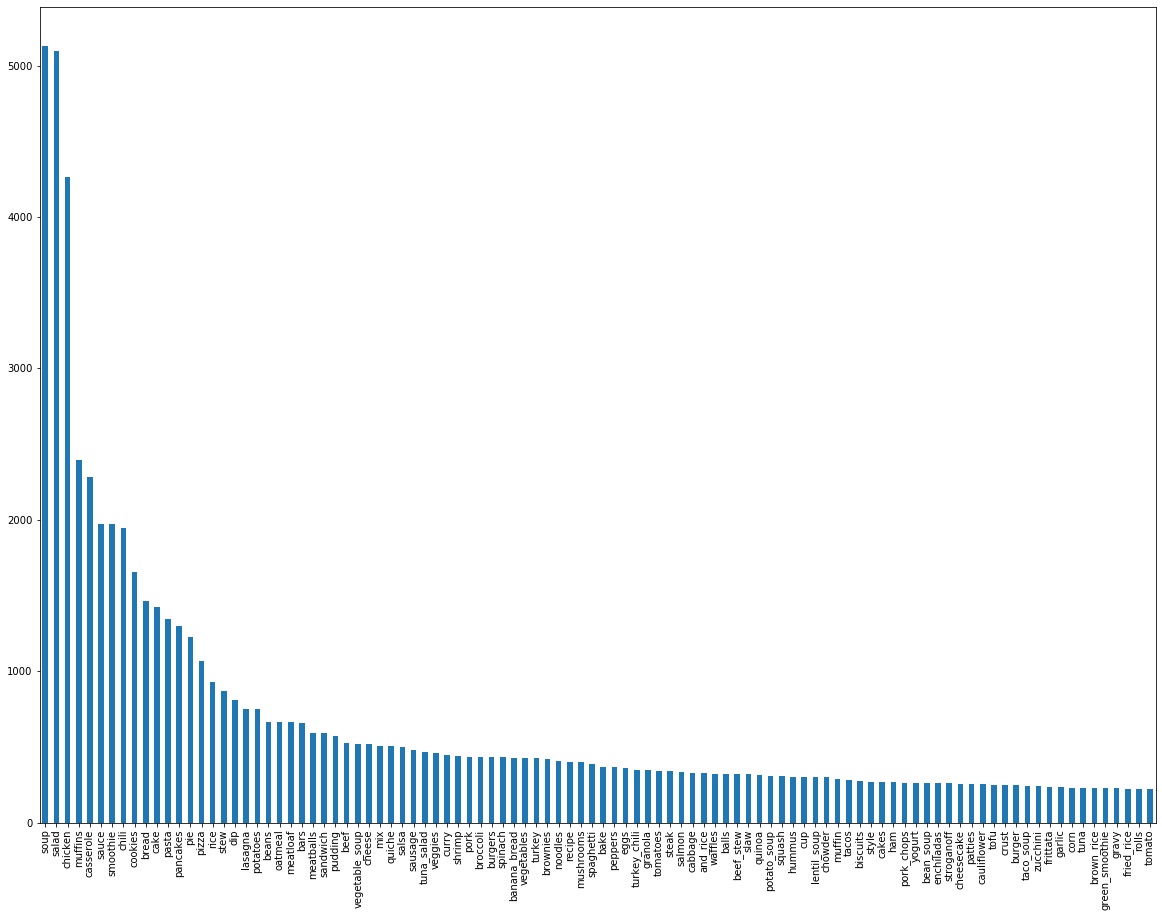

In [20]:
all_labels.value_counts().nlargest(100).plot.bar(figsize=(20, 15))

In [33]:
label_val_counts = all_labels.value_counts()
label_val_counts.shape

(7677,)

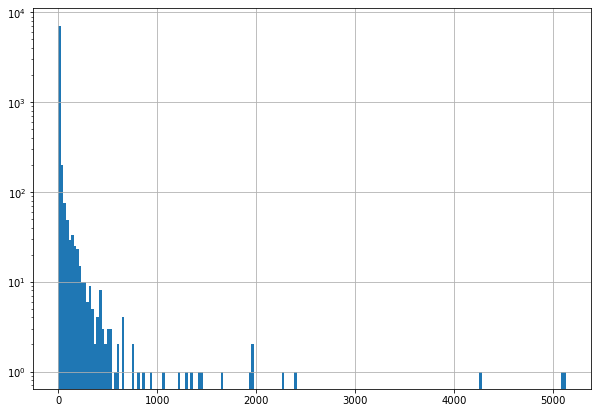

In [34]:
label_val_counts.hist(bins=200, log=True, figsize=(10, 7))

In [51]:
relevant_labels = set(
    label_val_counts[label_val_counts >= LABEL_MIN_COUNT].index.tolist()
)
len(relevant_labels)

357

## Evaluation

In [60]:
df_recipes["filtered_labels"] = df_recipes.labels.map(
    lambda labels: labels & relevant_labels
)

In [61]:
label_avail_mask = df_recipes.filtered_labels.map(lambda l: len(l) > 0)

In [90]:
df_recipes[label_avail_mask].sample(20)

,recipe_id,title,total_calories,url,servings,labels,filtered_labels
241523,995818,grain free meatloaf,321.7,https://recipes.sparkpeople.com/recipe-detail....,6.0,{meatloaf},{meatloaf}
260712,1100034,Tomato Basil Soup,71.5,https://recipes.sparkpeople.com/recipe-detail....,6.0,{soup},{soup}
444710,2141871,Grilled Lamb Chops w/Roasted Potatoes & Green ...,489.2,https://recipes.sparkpeople.com/recipe-detail....,1.0,{green_beans},{green_beans}
419318,1989916,Low Carb Chocolate Peppermint or Peanut Butter...,89.7,https://recipes.sparkpeople.com/recipe-detail....,22.0,"{peppermint, cups}",{cups}
448084,2162103,Turkey Sheppard Pie,280.8,https://recipes.sparkpeople.com/recipe-detail....,6.0,{pie},{pie}
31623,118429,Southwest Bean Chili - Homemade,216.6,https://recipes.sparkpeople.com/recipe-detail....,11.0,{homemade},{homemade}
20741,80848,"Stuffed Peppers with rice, lentils, roasted to...",301.4,https://recipes.sparkpeople.com/recipe-detail....,5.0,"{stuffed_peppers, spinach}","{stuffed_peppers, spinach}"
185904,708258,Potato Soup with carrots,116.9,https://recipes.sparkpeople.com/recipe-detail....,7.0,"{carrots, potato_soup}","{carrots, potato_soup}"
313097,1389384,Faked Beans,311.1,https://recipes.sparkpeople.com/recipe-detail....,4.0,{beans},{beans}
290432,1265988,Root Vegetable Casserole,248.4,https://recipes.sparkpeople.com/recipe-detail....,4.0,{casserole},{casserole}


In [79]:
f"Recipes without Label: ~{int(df_recipes[~label_avail_mask].shape[0] / df_recipes[label_avail_mask].shape[0] * 100)}%"

'Recipes without Label: ~19%'

### The Bad

In [92]:
bad_examples = [
    "Keema (Ground Beef Casserole) My Version",
    "My Improvised Dahl Recipe",
    "mac and cheese",
    "My version of Spaghetti Squash Baked Casserole",
    "Curry Chicken and Quinoa",
    "Eggplant Parmesan",
    "Green Diet Drink",
    "Gluten-Free Hawaiian Sweet Bread",
    "Mother's Okra & Tomato Gumbo (3/4 cup)",
    "Tortilla Soup (vegetarian)",
    "No Sugar Added Mixed Berry Crisp",
    "Amazing Tuna Salad Lettuce roll ups",
    "Southwest Bean Chili - Homemade",
]

In [148]:
df_bad_examples = df_recipes[df_recipes.title.isin(bad_examples)][
    ["title", "labels", "filtered_labels"]
]
df_bad_examples["sent"] = sents.map(lambda s: " ".join(s))
df_bad_examples = df_bad_examples.loc[
    df_bad_examples[["title"]].drop_duplicates().index
]

In [144]:
df_bad_examples

,title,labels,filtered_labels,sent
187500,Eggplant Parmesan,{parmesan},{parmesan},eggplant parmesan
74626,No Sugar Added Mixed Berry Crisp,{sugar},{sugar},no sugar added mixed berry crisp
169491,mac and cheese,{and_cheese},{and_cheese},mac and cheese
316405,Curry Chicken and Quinoa,"{quinoa, chicken}","{quinoa, chicken}",curry chicken and quinoa
487717,Gluten-Free Hawaiian Sweet Bread,"{gluten_free, bread}","{gluten_free, bread}",gluten free hawaiian sweet bread
375374,Mother's Okra & Tomato Gumbo (3/4 cup),{cup},{cup},mother okra tomato gumbo cup
243130,Keema (Ground Beef Casserole) My Version,"{casserole, version}","{casserole, version}",keema ground beef casserole my version
33533,Amazing Tuna Salad Lettuce roll ups,{ups},{ups},amazing tuna salad lettuce roll ups
302390,Tortilla Soup (vegetarian),{vegetarian},{vegetarian},tortilla soup vegetarian
580420,My Improvised Dahl Recipe,{recipe},{recipe},my improvised dahl recipe


In [158]:
def render_spacy(title):
    sent = df_bad_examples[df_bad_examples.title == title].iloc[0].sent
    print(sent)
    doc = nlp(sent)
    return displacy.render(doc, style="dep")

In [159]:
for e in bad_examples:
    render_spacy(e)

keema ground beef casserole my version


my improvised dahl recipe


mac and cheese


my version of spaghetti squash baked casserole


curry chicken and quinoa


eggplant parmesan


green diet drink


gluten free hawaiian sweet bread


mother okra tomato gumbo cup


tortilla soup vegetarian


no sugar added mixed berry crisp


amazing tuna salad lettuce roll ups


southwest bean chili homemade
